# paper wrapup - [Attention is All you need](https://arxiv.org/abs/1706.03762)

## Problem

### LSTM, GRU don't scale well

- Recurrent
  - 기존의 Sequence Modeling을 위해 사용되던 LSTM, GRU는 재귀적 특성(Sequence)으로 인해 Training 병렬화에 제약을 지님
  - 여기서 재귀적 특성이란 LSTM 등은 n번째 output을 계산하기 위해서는 n-1번째 계산의 결과물인 hidden state를 필요로하는 것이다.
    ```
    Y0, H0 = RNN(X0)
    Y1, H1 = RNN(X1, H0)
    Y2, H2 = RNN(X2, H1) = RNN(X2, RNN(X1, RNN(X0)[1])[1])

    ```
  - 위 간략한 코드형 표현에서 보듯, 2번째 입력의 결과인 Y2는 X0까지 RNN 함수를 3번 계산해야 하며
  - BPTT (Back Propagation Through Time): Back propagation을 위해서는 이 함수의 계산뿐 아니라 중간에 생성된 모든 상태값들을 메모리에 저장하고 있어야 한다.
  - 그리고 이는 RNN의 기반 Network의 Depth가 증가하면서 기하급수적으로 연산 복잡도가 증가하게된다.
  - Seq: N 그리고 Depth: D일 때 O(N x D)의 연산 복잡도를 갖게됨
  - Training에 있어서 BPTT로 인한 Memory 복잡도는 Sequence의 의존도 모델의 길이가 길어질 수록, 그리고 Network이 Deep해질 수록 기하급수적으로 증가하게된다.
  
    ![unroll_rnn](./assets/unroll_rnn.png)


- 그리고 특히 Parallelization의 한계를 극복하기 위해서 Convnet 기반의 여러 방식들(ByteNet, ConvS2S)이 제안되었으나 이들은 Sequence 상의 임의의 2지점의 관계를 모델링하는데 있어 상대적으로 높은 연산 복잡도를 가지고 있어서 Sequence상의 멀리 떨어진 요소간의 특징을 학습시키는데 제약을 가지고 있었다.
  - ConvS2S는 O(n)
  - ByteNet는 O(logN)
- 즉, long distance의 의존성을 적절하게 다룰 수 있으면서 동시에 병렬연산에 유리한 방법의 필요

### Transformers

- Transformer는 두 지점의 거리 N에 대해서 O(1)의 복잡도를 제공. 즉, Sequence의 두 위치간의 연관성을 계산함에 있어서 그 사이의 간격에 따른 연산 및 메모리 증가가 그만큼 적다는 의미
- Self-Attention은 Reading Comprehension, Semantic Representation, 등에 뛰어난 성능을 보였음
- Transfomer는 RNN이나 CNN 등을 사용하지 않고 순수하게 Self-Attention만을 사용한 최초의 사례

### Model Architecture

Encoder-Decoder Architecture

#### Encoder

- 6 identical layers
- each layer
  - multi-head self-attention (w/ residual connection)
  - position-wise feedforward (w/ residual connection)

```python

layer_1 = LayerNorm(MultiHeadSelfAttention(x) + x)
layer_2 = LayerNorm(PositionWiseFeedforward(x) + x)

```

#### Decoder

- 6 identical layers
- each layer
  - multi-head self-attention (w/ residual connection)
  - multi-head attention (w/ residual connection)
  - position-wise feedforward (w/residual connection)

```python

layer_1 = LayerNorm(MultiHeadAttention(x) + x)
layer_2 = LayerNorm(MultiHeadAttention(qk: encoder_output, v: x))
layer_3 = LayerNorm(PositionWiseFeedforward(x) + x)

```
  

## Scaled dot-product attention

- Attention의 주요 알고리즘으로 Scaled dot-product attention을 사용
- dot-product
  - attention을 구하는 연산으로 MatMul을 사용
- scaled
  - dimension of key and value. 즉, word embedding vector의 dimension dk
  - 1/sqrt(dk)로 attension weight을 scaling


```python
ScaledDotProduct(Q,K,V) = Softmax(Q@K.T / sqrt(dk))@V
```


In [1]:
import torch
import math

class ScaledDotProductAttention(torch.nn.Module):

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
    
    def forward(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        # input should have (B,N,d_model) where B is batch size, N is length of sequence, d_model is the dimension of word embedding vector
        # q (B,N,d_model) , k (B,N,d_model)
        # qk = (B,N,N)
        d_k = k.size(2) # d_model
        scaled_qk: torch.Tensor = q@torch.transpose(k, 2, 1) * (1 / math.sqrt(d_k))
        # mask should be tensor of bool (B,N,N)
        if mask is not None:
            scaled_qk = scaled_qk.masked_fill(mask.bitwise_not(), float('-inf'))
        attention_weights = torch.softmax(scaled_qk, dim=-1)
        return  attention_weights @  v
        


## From the outside of the ScaledDotProductAttention
    
batch_size = 4
seq_length = 8
d_model = 32

inputs = torch.rand((batch_size, seq_length, d_model))
attention_input_projection = torch.nn.Linear(d_model, 3 * d_model)
single_attention_head = ScaledDotProductAttention()

qkv_bundle:torch.Tensor = attention_input_projection(inputs) # shape of (batch_size, seq_length, d_model) so we have to split this tensor into Q,K,V
q,k,v = qkv_bundle.split(d_model, -1) # now we have q,k,v
# now we assume that we need causal mask for training here
# causal mask is sqaure matrix of (seq_length, seq_length) and all the values lower diagonal elements are `True` because we'll use masked_fill later

mask = torch.tril(torch.ones(seq_length, seq_length, dtype=torch.bool)).unsqueeze(0) # we have to unsqueeze here, so it can be broadcasted

fake_masked_attention_weights = torch.rand((batch_size, seq_length, seq_length)).masked_fill(mask.bitwise_not(), float('-inf'))
print(f"Shape of Mask : \n{fake_masked_attention_weights[0]}")
output_of_attention_head = single_attention_head(q,k,v,mask) # the output of attention head is (batch_size, seq_length, d_model) it's same to the input
print(f"Shape of Attention Output:\n{output_of_attention_head.shape}")

Shape of Mask : 
tensor([[0.2459,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.7196, 0.3789,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.8894, 0.9544, 0.1464,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.8671, 0.3182, 0.6044, 0.4743,   -inf,   -inf,   -inf,   -inf],
        [0.2829, 0.1783, 0.8862, 0.1979, 0.3643,   -inf,   -inf,   -inf],
        [0.2122, 0.9664, 0.8087, 0.9904, 0.9630, 0.5235,   -inf,   -inf],
        [0.2935, 0.9949, 0.4358, 0.9179, 0.6529, 0.5556, 0.7767,   -inf],
        [0.1753, 0.5783, 0.9280, 0.9879, 0.8191, 0.5479, 0.0978, 0.6957]])
Shape of Attention Output:
torch.Size([4, 8, 32])


## Multi-Head attention

- d_model 즉, Query, Key ,Value의 word embedding vector를 다수의 sub vector로 나누어서 각 sub vector를 입력으로 하는 scaled dot-product attention 다수를 조합하여 하나의 Attention block을 구성함.

```python
MultiHeadAttention(Q,K,V,n_heads) = concat(*[ScaledDotProduct(linear(qi),linear(ki),linear(vi)) for qi,ki,vi in zip(Q.split(n_heads), K.split(n_heads), V.split(n_heads))])
```



In [2]:

import torch

class MultiHeadAttention(torch.nn.Module):

    def __init__(self, d_model:int, n_head:int, device=None, dtype: torch.dtype=torch.float32, dropout:float=0.2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.n_head = n_head
        self.d_head = d_model // n_head
        self.dropout = dropout

        self.qkv_proj = torch.nn.Sequential(
            torch.nn.Linear(d_model, 3 * d_model, device=device, dtype=dtype), 
            torch.nn.Dropout(dropout))

        self.attns = torch.nn.ModuleList([ScaledDotProductAttention() for _ in range(n_head)])
        
        self.output_linear = torch.nn.Linear(d_model, d_model, device=device, dtype=dtype)
        self.out_drop = torch.nn.Dropout(dropout)

        
    def forward(self, input: torch.Tensor, mask: torch.Tensor=None) -> torch.Tensor:
        if len(input.shape) == 2:
            input = input.unsqueeze(0)
        if len(input.shape) != 3:
            raise ValueError(f'unsupported tensor shape: {input.shape}, should be form of (B,N,d)')
        
        batch_size,seq_n, d_model = input.shape
        qkv_bundle: torch.Tensor = self.qkv_proj(input)
        q,k,v = qkv_bundle.split(d_model,-1)
        
        q = q.view((batch_size, seq_n, -1, self.d_head)).transpose(1, 2)
        k = k.view((batch_size, seq_n, -1, self.d_head)).transpose(1, 2)
        v = v.view((batch_size, seq_n, -1, self.d_head)).transpose(1, 2)
        # now Q,K,V have shape of (batch_size, seq_n, n_head, d_head)


        attn_output = torch.concat([self.attns[i].forward(q[:,i,:,:].view((batch_size,seq_n,self.d_head)), 
                                            k[:,i,:,:].view((batch_size,seq_n, self.d_head)), 
                                            v[:,i,:,:].view((batch_size,seq_n, self.d_head)),mask=mask) for i in range(self.n_head)],dim=-1)
        
        return self.out_drop(self.output_linear(attn_output))





## From the outside of the MultiHeadAttention
    
batch_size = 4
seq_length = 8
d_model = 32
n_head = 4

inputs = torch.rand((batch_size, seq_length, d_model))
attention_input_projection = torch.nn.Linear(d_model, 3 * d_model)
multi_head_attention = MultiHeadAttention(d_model=d_model, n_head=n_head)

mask = torch.tril(torch.ones(seq_length, seq_length, dtype=torch.bool)).unsqueeze(0) # we have to unsqueeze here, so it can be broadcasted

fake_masked_attention_weights = torch.rand((batch_size, seq_length, seq_length)).masked_fill(mask.bitwise_not(), float('-inf'))
print(f"Shape of Mask : \n{fake_masked_attention_weights[0]}")
output_of_attention_head = multi_head_attention(inputs,mask) # the output of attention head is (batch_size, seq_length, d_model) it's same to the input
print(f"Shape of Attention Output:\n{output_of_attention_head.shape}")

Shape of Mask : 
tensor([[0.3518,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.5559, 0.3013,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.7481, 0.0082, 0.5323,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.0568, 0.9521, 0.4220, 0.5792,   -inf,   -inf,   -inf,   -inf],
        [0.6583, 0.8099, 0.1046, 0.7966, 0.3045,   -inf,   -inf,   -inf],
        [0.7281, 0.9570, 0.5825, 0.2283, 0.3014, 0.2147,   -inf,   -inf],
        [0.6397, 0.0203, 0.5929, 0.6845, 0.0837, 0.2638, 0.4979,   -inf],
        [0.8361, 0.7745, 0.3687, 0.2547, 0.5314, 0.9814, 0.2705, 0.8223]])
Shape of Attention Output:
torch.Size([4, 8, 32])


### `Masking` in Masked Attention

- Masking은 Scaled(Q@K.T)의 결과인 Attention Score에서 QnKm (where m > n)에 있는 값들을 -inf으로 변환한다.
- 이는 GPT와 같은 Autoregressive 모델의 주요한 목적, 즉, Sequence에서 한쪽의 정보를 기반으로 그 다음에 올 정보를 추정해야하는 모델에서 
- 추정의 정답 즉, Ground Truth에 대한 정보가 Training에 포함되는 것을 막기 위함이다.

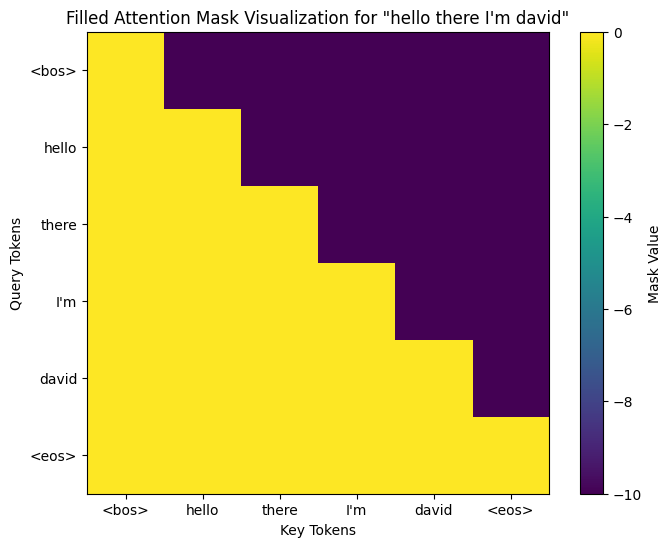

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Example sequence including special tokens
sequence = ["<bos>", "hello", "there", "I'm", "david", "<eos>"]
seq_length = len(sequence)

# Creating a mask with large negative numbers for visualization
filled_mask = np.triu(np.ones((seq_length, seq_length)), k=1) * -10

# Plotting the filled mask
plt.figure(figsize=(8, 6))
plt.imshow(filled_mask, cmap='viridis')
plt.colorbar(label='Mask Value')
plt.title('Filled Attention Mask Visualization for "hello there I\'m david"')
plt.xlabel('Key Tokens')
plt.ylabel('Query Tokens')
plt.xticks(ticks=range(seq_length), labels=sequence)
plt.yticks(ticks=range(seq_length), labels=sequence)
plt.show()


## Position-wise feedforward

- Linear - Relu - Linear
- dimension of hidden is 4 times of input
- but we'll use GELU instead of ReLU following the GPT-2 paper

In [4]:
import torch

class PositionWiseFeedforward(torch.nn.Module):

    def __init__(self, d_model:int, device, dtype: torch.dtype=torch.float32, dropout=0.2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.pwff = torch.nn.Sequential(torch.nn.Linear(d_model, d_model * 4, device=device,dtype=dtype), 
                                            torch.nn.GELU(), 
                                            torch.nn.Linear(4* d_model, d_model, device=device, dtype=dtype), 
                                            torch.nn.Dropout(dropout))
        
    def forward(self, input: torch.Tensor)-> torch.Tensor:
        return self.pwff.forward(input)




## Transformer Layer

- GPT논문의 Transformer layer는 Attention is all you need의 transformer는 Encoder 유사한 구조로 residual connection을 갖는 Multi-head attention과 position wise feedforward의 2개의 sublayer로 구성되어 있고 각 sublayer의 출력에 layer norm이 추가되는 형태
- Encoder와 Cross Attention의 sublayer를 없애고 MHA(Multi-Head Attention Layer) + PWFF (Poisition-Wise Feedforward)만으로 Transformer block을 구성
- 첫 GPT 논문에서는 이러한 transformer block 12개를 쌓아 올린 형태의 Network

### Normalization

- AAYN의 구조에서는 Add -> LayerNorm의 순서 residual 연결을 sublayer의 입력과 병합하였다. 이를 PostNorm이라고 한다.
  ```
  output = LayerNorm(input + sublayer(input))
  ```
- GPT3에서에서는 PreNorm 즉, sublayer의 계산보다 먼저 layernorm을 계산하고 sublayer의 output에 직접 residual connection을 적용하는 방식을 적용
  ```
  output = input + sublayer(LayerNorm(input))
  ```


In [5]:
import torch
from typing import Tuple

class Transformer(torch.nn.Module):

    def __init__(self, n_head, d_model, device, dtype:torch.dtype=torch.float32,dropout:float=0.2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.input_norm = torch.nn.LayerNorm(d_model, device=device, dtype=dtype)
        self.mha = MultiHeadAttention(d_model=d_model, n_head=n_head, device=device, dtype=dtype, dropout=dropout)
        self.mha_lnorm = torch.nn.LayerNorm(d_model, device=device,dtype=dtype)
        self.pw_ff = PositionWiseFeedforward(d_model=d_model, device=device, dtype=dtype, dropout=dropout)

    def forward(self, data:Tuple[torch.Tensor]) -> torch.Tensor:
        # Pre-LayerNormalization from GPT-3, (note: Post-LayerNormalization is used for GPT-2 and original paper)
        input, attention_mask = data

        norm_input = self.input_norm.forward(input)
        mha_output = input + self.mha.forward(norm_input, attention_mask)
        norm_mha_output = self.mha_lnorm(mha_output)
        return (mha_output + self.pw_ff.forward(norm_mha_output), attention_mask)
    

In [6]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # use CUDA whenever it's available

batch_size = 8
d_model = 1024
seq_length = 512
n_head = 8

inputs = (torch.rand((batch_size, seq_length, d_model), device=device), torch.tril(torch.ones((1, seq_length, seq_length), dtype=torch.bool, device=device)))
transformer = Transformer(n_head=n_head, d_model=d_model, device=device, dtype=torch.float)

output = transformer.forward(inputs)
output

(tensor([[[ 0.1777,  0.5876, -0.5532,  ...,  0.5368,  0.5570,  0.2788],
          [ 0.3513,  0.5145,  0.8241,  ...,  0.7984,  0.4468,  0.2498],
          [ 0.5713,  0.7557,  0.3160,  ...,  0.8272,  0.4424, -0.0245],
          ...,
          [ 0.0260,  0.9327,  0.9356,  ...,  0.2844,  0.2996,  0.4812],
          [ 0.9173,  0.4515,  0.6859,  ...,  0.3426, -0.0790,  0.1684],
          [ 0.3067,  0.1036,  1.1357,  ...,  0.1852,  0.0578,  1.0119]],
 
         [[ 0.4123, -0.4034,  0.7813,  ...,  0.8556,  1.2440,  0.9357],
          [ 0.0615,  0.0576,  0.0419,  ...,  0.8049, -0.4240,  1.8177],
          [ 0.3274,  0.6522,  0.1778,  ...,  0.7037, -0.1618,  0.8464],
          ...,
          [ 0.4570, -0.2866,  0.7866,  ...,  1.0251,  0.3749,  0.4157],
          [-0.4504, -0.1523,  0.7623,  ...,  0.3446,  0.3034,  0.9105],
          [-0.3045,  0.1190,  0.6420,  ...,  0.8062, -0.2881,  0.8501]],
 
         [[ 0.8382,  0.8076,  1.1609,  ...,  0.1307,  0.4825,  2.1286],
          [ 0.2370,  0.6695,

## Embedding & Tokenization

- Text를 적절한 Numerical Representation으로 변형을 하기 위해서는 크게 2가지의 처리 단계를 필요로 하는데 이는 Tokenization과 Embedding이다.


### Tokenization
- Text를 최소 단위로 쪼개어 각 의미 단위에 고유한 ID를 부여하는 것.
- 최소 단위로 쪼개는 방식에 따라 Word Level Tokenization, Character Level Tokenization 부터 Subword Tokenization 등 다양한 방법이 있다. 
- 단, 신규 어휘의 확장(합성어 등)에 유연하게 대응할 수 있는 장점을 지닌 Subword 방식을 많이 쓰고 있으며 BPE라는 방식이 유명하다.
  

In [7]:
import torch

vocab_size = 500
dense_rep = 50
batch = 8
seq = 64

input = torch.ones((batch, seq), dtype=torch.int) ## test input

embedding = torch.nn.Embedding(vocab_size, dense_rep) ## convert the token_id to dense vector

output = embedding.forward(input=input)

output.shape # would be (8,64,50)


torch.Size([8, 64, 50])

### Embedding

- Embedding은 token을 다차원의 vector로 변환시키는 기능을 한다.
- Tokenizer에 의해 고유하게 변환될 수 있는 ID의 다양성, 예를 들어 단어를 기준으로 한다면 어휘의 종류를 `vocab_size` 그리고 word vector의 dimension을 n_embed라고 하면 Embedding의 parameter는 ```vocab_size * n_embed```개가 된다.


In [8]:
import torch

vocab_size = 50000 # total number of possible ID for input token
n_embed = 1024 # dense vector representation for each token

embedding = torch.nn.Parameter(data=torch.zeros((vocab_size, n_embed)), requires_grad=True)

input_ids = [1,2,3,4]

w_vectors = torch.stack([embedding[id] for id in input_ids])
print(f"Shape of Word Vectors: \n{w_vectors.shape}")

                  

Shape of Word Vectors: 
torch.Size([4, 1024])


### Positional Encoding - Absolute Position Encoding from AAYN paper
- Embedding을 통하여 언어를 Deep Learning에 활용할 수 있는 Dense Vector로 변환할 수 있지만 이렇게 생성된 Vector는 해당 token의 위치를 고려하지 않는다.
- 따라서 각 token의 상대적 배열 순서에 대한 정보를 추가하기 위한 수단이 필요하며 이것이 바로 Positional Encoding이다.
- AAYN 논문에서는 sinusodial function을 이용하여 이러한 Positional Encoding을 구현하였다.
  - 단순히 position에 따라 embedding vector에 동일한 값을 적용하는 방식이 아닌
  - embedding vector의 subspace에따라서 sinusoid의 period가 다르게 적용되도록 embedding dimension을 position embedding의 변수로 추가
  - 이로써 sinusoidal function의 반복적 특징에 의한 값의 중복을 없애고
  - suquence 내의 모든 값에 대해서 고유한 위치 정보를 할당할 수 있음
- 이러한 경우 PE는 learnable parameter가 아닌 position과 word vector dimension에 따라 정해진 상수임

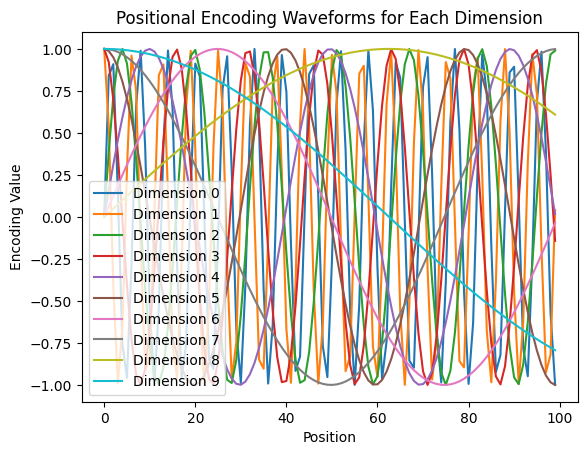

In [9]:
import torch
import matplotlib.pyplot as plt

def positional_embedding(d_model, max_length, dtype=None, device=None):
    div_even = torch.pow(10000, torch.arange(0, d_model // 2, dtype=dtype, device=device) * 2 / d_model)
    div_odd = torch.pow(10000, torch.arange(0, d_model // 2, dtype=dtype, device=device) * 2 / d_model)
    pos = torch.arange(0, max_length, device=device, dtype=dtype).unsqueeze(-1)
    pe = torch.zeros((max_length, d_model))
    pe[:,0::2] = torch.sin(pos / div_even)
    pe[:,1::2] = torch.cos(pos / div_odd)
    return pe.requires_grad_(False)

# Parameters
d_model = 20
max_length = 100

# Generate positional embeddings
pe = positional_embedding(d_model, max_length)

# Plot each dimension separately
for i in range(int(d_model / 2)):
    plt.plot(pe[:, i].numpy(), label=f'Dimension {i}')

plt.title('Positional Encoding Waveforms for Each Dimension')
plt.xlabel('Position')
plt.ylabel('Encoding Value')
plt.legend()
plt.show()


### Positional Encoding - Learnable Positional Encoding
- Karpathy의 nanoGPT의 경우 `torch.nn.Embedding`을 그대로 positional embedding에 사용하였다.
- 실제 AAYN 논문에도 제안된 sinusoidal method와 성능측면에서 큰 차이가 없었음을 언급하고 있다.
- 하지만 learnable embedding의 경우 학습에 의해서 생성되는 것이기 때문에 longer sequence에 대한 대응에 제약이 상대적으로 더 클것이고
- 일정한 규칙을 갖는 sinudoidal method가 이러한 측면에서 더 우수한 일반화 성능을 보일 것이라는 이유에서 sinudoidal 방법을 채택하였다고 언급하고 있음

In [10]:
import torch

max_length = 512
d_model = 768
batch_size = 4
seq_n = 32

wpe = torch.nn.Embedding(max_length, d_model)
inputs = torch.rand((batch_size, seq_n, d_model))

pe = wpe(torch.arange(0, inputs.size(1))).unsqueeze(0)
embedding = inputs + pe


## ToyGPT

### Structure

- 위에 정의된 각 module을 조합하여 GPT 모델을 아래와 같이 구성
- Positional Embedding은 learnable absolute position encoding 방식을 사용 (Karpathy의 nanoGPT와 동일)
- Sequential로 묶여 있는 연속된 Transformer layers와 이후 dense vector에서 token logits output을 얻기 위한 linear layer로 구성

#### Weight Tying

- Input embedding layer(token_ids => dense word vector)와 output embedding layer (dense word vector => token_ids)의 weight을 share (tying)함으로써 얻을 수 있는 이득은
  - Parameter의 효율적 사용과 동시에 전반적인 성능의 향상
  - inference 시 latency 감소

### training parameter

- AdamW optimizer를 사용
- learning rate
  -  GPT-2 paper의 설정을 일부 사용
  -  lr: 2.5e-4
  -  2000 steps of soft warmup
  -  weight initialization N[0, 0.02]
  -  dropout: 0.1 (attention, residual, embedding)
  -  weight decay: 0.1 (which is from GPT-3 paper)

In [11]:
from typing import Any, Tuple, Dict
from lightning.pytorch.utilities.types import STEP_OUTPUT, OptimizerLRScheduler
import torch
import lightning as L


class ToyGPT(L.LightningModule):

    def __init__(self, 
                 vocab_size:int, 
                 block_size:int,
                 n_embed:int, n_head:int, n_layer:int, pad_id:int=None,  device=None, 
                 dtype:torch.dtype=torch.float32, dropout:float=0.1, lr=2.5e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01, name: str='toygpt', *args, **kwargs) -> None:
        
        super().__init__(*args, **kwargs)
        self.save_hyperparameters(ignore=['dtype', 'device'])
        self.name = name
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.decay = weight_decay
        self.output_linear = torch.nn.Linear(n_embed, vocab_size, device=device, dtype=dtype)
        self.embedding = torch.nn.Embedding(vocab_size, n_embed, padding_idx=pad_id) 
        # I referred to the nanoGPT of Karpathy about weight tying. embedding layer that convert token IDs to dense vector and the linear layer followed by softmax at the output of language model has directly reversed functionality to each other.
        # benefit of weight tying
        self.embedding.weight = self.output_linear.weight 


        self.pos_embedding = positional_embedding(d_model=n_embed, max_length=block_size, device=device, dtype=dtype).unsqueeze(0)
        self.embedding_dropout = torch.nn.Dropout(dropout)
        self.transformers = torch.nn.Sequential(*[Transformer(n_head=n_head, d_model=n_embed, device=device, dtype=dtype, dropout=dropout) for _ in range(n_layer)])
        self.loss = torch.nn.CrossEntropyLoss(ignore_index=pad_id)
        self.apply(self._init_weights)

    
    

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, torch.nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def configure_optimizers(self) -> OptimizerLRScheduler:
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, betas=self.betas, eps=self.eps, weight_decay=self.decay)
        lr_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=optimizer,schedulers=[
            torch.optim.lr_scheduler.LinearLR(optimizer=optimizer, start_factor=self.eps, total_iters=2000, end_factor=1),
            torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=4000, eta_min=(self.lr / 10))
        ],milestones=[2000])
        lr_scheduler_config = {
            "scheduler": lr_scheduler,
            "interval": "step",
            "frequency": 1,
            "name": "CosineWithWarmUp",
        }
        return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_config}

    def forward(self, input: Dict[str, torch.Tensor]) -> torch.Tensor:
        # X should have shape of (B,N)
        X: torch.Tensor = input["input_ids"]
        attention_mask: torch.Tensor = input["attention_mask"]
        if len(X.shape) == 1:
            X = X.unsqueeze(0)
        N = X.size(1)
        
        X_wemb = self.embedding(X) + self.pos_embedding[:,:N,:] # word embedding + postion embedding
        hs, _ = self.transformers.forward((X_wemb, attention_mask.bool()))
        return torch.softmax(self.output_linear.forward(hs[:,-1,:]), -1)


    def training_step(self, data: Tuple[torch.Tensor], batch_index:Any, *args: Any, **kwargs: Any) -> STEP_OUTPUT:
        
        X = data["input_ids"]

        input:torch.Tensor = X[:,:-1]
        target:torch.Tensor = X[:,1:].long()
        B,n = input.shape

        attention_mask:torch.Tensor = torch.tril(torch.ones((n,n), device=input.device)).unsqueeze(0).expand((B,n,n)).bool()
        

        # X_wemb = self.embedding(input) + self.pos_embedding(torch.arange(0, input.shape[-1],device=input.device, dtype=torch.long)) # word embedding + postion embedding
        X_wemb = self.embedding(input) + self.pos_embedding[:,:n,:] # word embedding + postion embedding
        hidden_output, _ = self.transformers.forward((self.embedding_dropout(X_wemb), attention_mask))
        logits = self.output_linear.forward(hidden_output)
        # the sequencess of batch are now totally flatten into (B * n, logits), so we have to divide the loss by batch_size
        loss = self.loss(logits.view(-1, logits.size(-1)), target.reshape(-1))
        if batch_index % 10 == 0:
            lr = self.trainer.optimizers[0].param_groups[0]['lr']
            # log train loss not too much frequently
            self.log("train_loss", loss)
            self.log("lr", lr)

        return {"batch_index": batch_index, "loss":loss}
    

    def validation_step(self, data: Tuple[torch.Tensor], batch_index,*args: Any, **kwargs: Any) -> STEP_OUTPUT:
        
        X = data["input_ids"]

        input:torch.Tensor = X[:,:-1]
        target:torch.Tensor = X[:,1:].long()
        B,n = input.shape

        attention_mask:torch.Tensor = torch.tril(torch.ones((n,n), device=input.device)).unsqueeze(0).expand((B,n,n)).bool()

        X_wemb = self.embedding(input) + self.pos_embedding[:,:n,:] # word embedding + postion embedding
        hidden_output, _ = self.transformers.forward((self.embedding_dropout(X_wemb), attention_mask))

        logits = self.output_linear.forward(hidden_output)
        # the sequencess of batch are now totally flatten into (B * n, logits), so we have to divide the loss by batch_size
        loss = self.loss(logits.view(-1, logits.size(-1)), target.reshape(-1))
        self.log("val_loss", loss)
        return {"batch_index": batch_index, "val_loss":loss}
    
    
    def test_step(self, data: Tuple[torch.Tensor], batch_index, *args: Any, **kwargs: Any) -> STEP_OUTPUT:
       
        X = data["input_ids"]

        input:torch.Tensor = X[:,:-1]
        target:torch.Tensor = X[:,1:].long()
        B,n = input.shape

        attention_mask:torch.Tensor = torch.tril(torch.ones((n,n), device=input.device)).unsqueeze(0).expand((B,n,n)).bool()

        X_wemb = self.embedding(input) + self.pos_embedding[:,:n,:] # word embedding + postion embedding
        hidden_output, _ = self.transformers.forward((self.embedding_dropout(X_wemb), attention_mask))

        logits = self.output_linear.forward(hidden_output)
        # the sequencess of batch are now totally flatten into (B * n, logits), so we have to divide the loss by batch_size
        loss = self.loss(logits.view(-1, logits.size(-1)), target.reshape(-1))
        self.log("test_loss", loss)

        return {"batch_index": batch_index, "val_loss":loss}
    

/home/fritzprix/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Tokenizer

- Pre-trained GPT2 tokenizer will be used
- Wikisource.en will be used as training data
- Special Tokens
  - pad_token: `<pad>`
  - bos_token: `<|startoftext|>`
  - eos_token: `<|endoftext|>`
  


In [12]:
from transformers import PreTrainedTokenizer, GPT2Tokenizer

def get_tokenizer() -> PreTrainedTokenizer:
    
    tokenizer: PreTrainedTokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.add_special_tokens({"pad_token": "<pad>", "bos_token":"<|startoftext|>", "eos_token":"<|endoftext|>"}) # special 
    return tokenizer

tokenizer = get_tokenizer()
tokenizer

GPT2Tokenizer(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50257: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50258: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [20]:

import json

with open('config.json') as fp:
    configs = json.load(fp)

for config in configs:
    model = ToyGPT(vocab_size=len(tokenizer), pad_id=tokenizer.pad_token_id, device=device, **config)
    total_params = 0
    for param in model.parameters():
        total_params += param.numel()
    print(f'{model.name} : params {total_params / 1e6}M')


toyGPT.small : params 123.703635M
toyGPT.midium : params 253.055059M
toyGPT.large : params 1311.579219M


In [30]:
param_count = 0
for p in model.parameters():
    param_count += p.numel()

print(f"parameters : {param_count/1e6}")

parameters : 202.670163


# Model Parameter

- GPT2Tokenizer의 Vocab

## Dataset

- "wikimedia/wikisource", "20231201.en"
- HuggingFace의 Datasets와 Unstructured.io를 이용 Data의 download, pre-processing을 구현
- Lightening framework과 연동을 위해 LighteningDataModule을 구현


In [ ]:
from typing import Any, List, Dict

import lightning as L
from datasets import Dataset, load_from_disk, load_dataset
from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS
from transformers import PreTrainedTokenizer
from torch.utils import data
from unstructured.cleaners.core import (
    replace_unicode_quotes, clean, clean_ligatures
)
import re
from unstructured.cleaners.core import clean


### Pre-processing
- Text Cleansing
  - extra whitespace 제거
  - unicode quote 대체
  - ligatures 제거
- 이렇게 Cleansing된 Text를 완전한 Sentence 단위로 분절하여 Max Length에 맞도록 전처리하여 Local에 저장


In [ ]:
class SentenceChunker:
    """
    A class responsible for chunking text into sentences and tokenizing them
    according to a specified maximum length.

    Attributes:
        tokenizer (PreTrainedTokenizer): A tokenizer from the transformers library
                                         used for tokenizing sentences.
        max_length (int): The maximum token length for a single chunk.
    """

    def _split_into_sentences(self, text):
        """
        Splits the input text into sentences.

        The text is first cleaned to standardize it (removing extra whitespaces, 
        replacing unicode quotes, and removing ligatures). Then, it is split into 
        sentences using a regular expression that looks for sentence end markers 
        (., !, ?) followed by a whitespace.

        Args:
            text (str): The text to be split into sentences.

        Returns:
            List[str]: A list of sentences extracted from the input text.
        """
        # Clean the text and split it into sentences
        clean_text = replace_unicode_quotes(clean_ligatures(clean(text, extra_whitespace=True)))
        sentences = re.split(r'(?<=[.!?])\s+', clean_text)
        return [f'{sentence}' for sentence in sentences]

    def __init__(self, tokenizer: PreTrainedTokenizer, max_length:int) -> None:
        print('test v1.0')
        """
        Initializes the SentenceChunker with a tokenizer and a maximum length.

        Args:
            tokenizer (PreTrainedTokenizer): The tokenizer to be used for tokenization.
            max_length (int): The maximum token length for a single chunk.
        """
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __call__(self, batch, *args: Any, **kwds: Any) -> Any:
        """
        Processes a batch of text sequences by first splitting them into sentences,
        then encoding each sentence. The sentences are then chunked according to the 
        maximum length, ensuring no chunk exceeds this limit.

        Args:
            batch: A batch of text sequences.

        Returns:
            Dict[str, List]: A dictionary with two keys, 'success' and 'failure'.
                             'success' contains chunks that are within the max_length,
                             'failure' contains chunks that exceed the max_length.
        """
        # Handle single string inputs by wrapping them in a list
        if isinstance(batch, str):
            batch = [batch]


        # Split each sequence in the batch into sentences and encode them
        batch_of_chunks = [self._split_into_sentences(seq) for seq in batch]
        batch_of_encodings = [self.tokenizer.batch_encode_plus(chunks, return_length=True, add_special_tokens=True) for chunks in batch_of_chunks]

        result = {"success": [], "failure": []}
        success_batch_bucket = []
        failure_batch_bucket = []

        # Iterate over each sequence's encodings and chunk them
        for bi, encodings in enumerate(batch_of_encodings):
            bucket = []
            tokens_total = 0

            # Process each sentence in the sequence
            for n, token_count in enumerate(encodings["length"]):
                token_count += 1 # splitting sequence removes space between two adjacent sequence in the process, so 1 token is accounted
                # Handle sentences that exceed the max length
                if token_count > self.max_length:
                    failure_batch_bucket.append({"text":batch_of_chunks[bi][n], "length": token_count})
                    if len(bucket) > 0:
                        success_batch_bucket.append({"text":' '.join(bucket), "length": tokens_total})
                        bucket.clear()
                        tokens_total = 0
                    continue

                # Check if adding the sentence would exceed the max length
                if token_count + tokens_total > self.max_length:
                    # Current bucket is full, save and reset it
                    seq = ' '.join(bucket)
                    tokens = self.tokenizer.encode(seq)
                    if len(tokens) > self.max_length:
                        print(f"{len(tokens)} vs {self.max_length}")
                        assert False
                    success_batch_bucket.append({"text":seq, "length": tokens_total})
                    bucket.clear()
                    tokens_total = 0
                
                # Add the sentence to the current bucket
                bucket.append(batch_of_chunks[bi][n])
                tokens_total += token_count

            # Append the processed batches to the result
            result["success"].append([*success_batch_bucket])
            result['failure'].append([*failure_batch_bucket])
            success_batch_bucket.clear()
            failure_batch_bucket.clear()

        return result


### Loading
- shuffling
- batch tokenization



In [1]:
from typing import Any, List, Dict
import shutil

import random

import lightning as L
from datasets import Dataset, load_from_disk, load_dataset
from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS
from transformers import PreTrainedTokenizer
from torch.utils import data
from unstructured.cleaners.core import (
    replace_unicode_quotes, clean, clean_ligatures
)
import re
import os
from unstructured.cleaners.core import clean

import random

class SuccessCaseGenerator:
    def __init__(self, datasets: List[Dataset], transform=None) -> None:
        self.datasets = datasets
        self.transform = transform

    def __call__(self, *args: Any, **kwds: Any) -> Any:
        for ds in self.datasets:
            for b in ds["success"]:
                for seq in b:
                    if self.transform:
                        seq = self.transform(seq)
                    yield seq

def random_indices(total_elements, portion):
    # Calculate the number of elements to select
    number_to_select = round(total_elements * portion)

    # Generate a list of unique indices for selection
    selected_indices = random.sample(range(total_elements), number_to_select)

    # Calculate the not-selected indices
    all_indices = set(range(total_elements))
    not_selected_indices = list(all_indices - set(selected_indices))

    return selected_indices, not_selected_indices


class HuggingFaceCollectionModule(L.LightningDataModule):

    def __init__(self, tokenizer: PreTrainedTokenizer, 
                 paths:List[str],
                 subsets: List[List[str]],
                 max_length:int, 
                 batch_size:int,
                 clear_cache:bool=False,
                 train_size:float=0.9,
                 resume_pos = 0,
                 num_proc=15) -> None:
        super().__init__()
        self.name = '_'.join(paths)
        self.tokenizer = tokenizer
        self.paths = paths
        self.subsets = subsets
        self.max_length = max_length
        self.train_size = train_size
        self.batch_size = batch_size
        self.num_proc = num_proc
        self.clear_cache = clear_cache
        self.resume_pos = resume_pos
        self.dataset = None
        self.val_dataset = None
        self.train_dataset = None
        self.local_fdata_cache_path = f'cache/{self.name}/local_dscache'
        self.local_tdata_cache_path = f'cache/{self.name}/train_dscache'
        self.local_vdata_cache_path = f'cache/{self.name}/val_dscache'
        self.local_tokenized_cache_path = f'cache/{self.name}/tokenized'


    def prepare_data(self) -> None:

        full_dataset = None

        def transform(v:Dict[str, Any]) -> str:
            return {"length": v["length"], "text": f"<|startoftext|>{v['text']}<|endoftext|>"}
        
        if self.clear_cache:
            shutil.rmtree(self.local_fdata_cache_path, ignore_errors=True)
            shutil.rmtree(self.local_tdata_cache_path, ignore_errors=True)
            shutil.rmtree(self.local_vdata_cache_path, ignore_errors=True)
        
        if not os.path.exists(self.local_fdata_cache_path):

            sentence_chunker = SentenceChunker(self.tokenizer, self.max_length - 2)
            datasets = [load_dataset(path, subset)['train'].map(lambda b: sentence_chunker(b["text"]), batched=True, num_proc=self.num_proc).flatten()
             for i, path in enumerate(self.paths) for subset in self.subsets[i]]
                
            full_dataset = Dataset.from_generator(SuccessCaseGenerator(datasets, transform=transform))
            full_dataset = full_dataset.train_test_split(test_size=(1 - self.train_size), train_size=self.train_size)
            full_dataset.save_to_disk(self.local_fdata_cache_path)
        else:
            print('full data cached locally')
        
        if not (os.path.exists(self.local_tdata_cache_path) and os.path.exists(self.local_vdata_cache_path)):
            if full_dataset is None:
                full_dataset = load_from_disk(self.local_fdata_cache_path)
            visible_dataset = full_dataset['train'].shuffle()
            print(visible_dataset)
            val_selection, train_selection = random_indices(len(visible_dataset), (1 - self.train_size))
            val_dataset = visible_dataset.select(val_selection)
            train_dataset = visible_dataset.select(train_selection)
            val_dataset.save_to_disk(self.local_vdata_cache_path)
            train_dataset.save_to_disk(self.local_tdata_cache_path)
        else:
            print('load from local cache')

    def setup(self, stage: str) -> None:
        if self.dataset is None:
            self.dataset = load_from_disk(self.local_fdata_cache_path)
            self.val_dataset = load_from_disk(self.local_vdata_cache_path)
            self.train_dataset = load_from_disk(self.local_tdata_cache_path)

        return super().setup(stage)

    def _tokenize(self, data):
        inputs = data['text']
        return self.tokenizer.batch_encode_plus(inputs, return_tensors="pt", padding=True, return_length=True, max_length=self.max_length)

    
    def train_dataloader(self) -> TRAIN_DATALOADERS:
        if os.path.exists(self.local_tokenized_cache_path):
            train_dataset = load_from_disk(self.local_tokenized_cache_path)
        else:
            train_dataset = self.train_dataset.map(self._tokenize, batched=True, batch_size=self.batch_size).select_columns(["input_ids", "attention_mask"])
            train_dataset.save_to_disk(self.local_tokenized_cache_path)
        l = len(train_dataset)
        print(range(self.batch_size * self.resume_pos, l))
        train_dataset = train_dataset.select(range(self.batch_size * self.resume_pos, l))
        return data.DataLoader(train_dataset.with_format(type="torch"), num_workers=self.num_proc, batch_size=self.batch_size)
    
    #.skip(self.batch_size * self.resume_pos)
    def val_dataloader(self) -> EVAL_DATALOADERS:
        val_dataset:Dataset = self.val_dataset.map(self._tokenize, batched=True,  batch_size=self.batch_size).select_columns(["input_ids", "attention_mask"])
        return data.DataLoader(val_dataset.with_format(type="torch"), num_workers=self.num_proc, batch_size=self.batch_size)
    
    def test_dataloader(self) -> EVAL_DATALOADERS:
        test_dataset = self.dataset["test"].map(self._tokenize, batched=True, batch_size=self.batch_size).select_columns(["input_ids", "attention_mask"])
        return data.DataLoader(test_dataset.with_format(type="torch"), num_workers=self.num_proc, batch_size=self.batch_size)
    



/home/fritzprix/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
tokenizer = get_tokenizer()
block_size = 512
batch_size = 10

data_module = HuggingFaceCollectionModule(tokenizer, paths=['wikimedia/wikisource', "togethercomputer/RedPajama-Data-1T-Sample"],
                                              subsets=[
                                                  ['20231201.en'],
                                                  [None]
                                              ],
                                              max_length=block_size, 
                                              batch_size=batch_size, 
                                              num_proc=15, 
                                              train_size=0.99)
data_module.prepare_data()
data_module.setup("fit")
train_data = data_module.train_dataloader()
val_data = data_module.val_dataloader()
test_data = data_module.test_dataloader()

full data cached locally
load from local cache
range(0, 3112072)


Map:   0%|          | 0/31435 [00:00<?, ? examples/s]/home/fritzprix/miniconda3/envs/torch/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2636: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Map: 100%|██████████| 31753/31753 [00:33<00:00, 955.65 examples/s]


In [12]:
from tqdm import tqdm


def get_tokens_count(loader):
    overall_token_count = 0
    for data in tqdm(loader):
        token_lengths: torch.Tensor = data['input_ids']
        overall_token_count += token_lengths.numel()

    return overall_token_count

print(f"training : {get_tokens_count(train_data) / 1e9} billion tokens")
print(f"validation : {get_tokens_count(val_data) / 1e9} billion tokens")
print(f"test : {get_tokens_count(test_data) / 1e9} billion tokens")



100%|██████████| 311208/311208 [01:44<00:00, 2978.85it/s]


training : 1.500872004 billion tokens


100%|██████████| 3144/3144 [00:01<00:00, 2250.16it/s]


validation : 0.01516361 billion tokens


100%|██████████| 3176/3176 [00:01<00:00, 2327.45it/s]

test : 0.015308814 billion tokens


## Before Training
- 0.4B tokens의 training data는 Chinchilla Optimal의 

In [9]:
import torch

linear = torch.nn.Linear(768, 50000)
embedding = torch.nn.Embedding(50000, 768, _weight=linear.weight)
embedding.weight


Parameter containing:
tensor([[ 0.0052,  0.0134,  0.0017,  ..., -0.0174,  0.0166, -0.0307],
        [ 0.0002, -0.0323,  0.0198,  ..., -0.0058,  0.0178, -0.0146],
        [-0.0053, -0.0225, -0.0324,  ..., -0.0360,  0.0057, -0.0090],
        ...,
        [ 0.0152, -0.0125, -0.0077,  ..., -0.0211, -0.0165,  0.0218],
        [ 0.0021, -0.0226, -0.0088,  ..., -0.0015, -0.0064, -0.0059],
        [-0.0169,  0.0340,  0.0199,  ...,  0.0281,  0.0145,  0.0284]],
       requires_grad=True)

In [2]:


import os
import glob
from os.path import isfile, join

def get_last_modified_file(directory):
    files = glob.glob(os.path.join(directory, '*'))
    last_modified_time = 0
    last_modified_file = ''

    for file in files:
        if isfile(file):
            current_time = os.path.getmtime(file)
            if current_time > last_modified_time:
                last_modified_time = current_time
                last_modified_file = file

    return last_modified_file



get_last_modified_file('checkpoints')



'checkpoints/model-step=4000-val_loss=6.566.ckpt'

In [6]:
from model import ToyGPT

last_ckpt_file = get_last_modified_file('checkpoints')
model = ToyGPT.load_from_checkpoint(last_ckpt_file)
model.hparams

"betas":        (0.9, 0.999)
"block_size":   512
"dropout":      0.1
"eps":          1e-08
"lr":           0.0002
"n_embed":      768
"n_head":       12
"n_layer":      12
"name":         toygpt.small
"pad_id":       50257
"vocab_size":   50259
"weight_decay": 0.1

In [3]:
from model import ToyGPTModelConfig
import json

configs = [
    ToyGPTModelConfig(name='toyGPT.small', n_layer=12, n_head=8, block_size=512, n_embed=768).dict(),
    ToyGPTModelConfig(name='toyGPT.midium', n_layer=16, n_head=8, block_size=512, n_embed=1024).dict(),
    ToyGPTModelConfig(name='toyGPT.large', n_layer=24, n_head=16, block_size=512, n_embed=2048).dict(),
]


with open('config.json', 'w+') as fp:
    json.dump(configs, fp)


